Using genomic tools determined which variants causes disease in the patient with the following symptoms:
 - Autistic features
 - Developmental delay
 - Mild speech delay
 - Epilepsy (bilateral tonic-clonic seizures, lasting 1 min, recurring several times within 2 days, and then increased in frequency to five seizures per day).


# Installing

In [ ]:
!pip install spliceai pysam tensorflow transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 3.7 MB/s 
     |████████████████████████████████| 15.1 MB 28.5 MB/s 
     |████████████████████████████████| 4.7 MB 45.7 MB/s 
     |████████████████████████████████| 103 kB 55.5 MB/s 
     |████████████████████████████████| 6.6 MB 35.0 MB/s 
     |████████████████████████████████| 120 kB 50.1 MB/s 
  Created wheel for pyfaidx: filename=pyfaidx-0.7.1-py3-none-any.whl size=27747 sha256=f4fe727c7d28c0696b1ede25f05df3604cd3751d659fa53e5b7ba1d8b834e18d
  Stored in directory: /root/.cache/pip/wheels/1a/d6/99/7334c4d11bfb574e6d6ea706256053b268a12f2127af1cfd40
Successfully built pyfaidx


In [ ]:
!git clone https://github.com/AIRI-Institute/GENA_LM.git

Cloning into 'GENA_LM'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 40 (delta 5), reused 35 (delta 3), pack-reused 0
Unpacking objects: 100% (40/40), done.


----------------------------------------------------------------------

# import py modules

In [ ]:
import sys
import requests
from pathlib import Path

import os
import numpy as np
import pandas as pd
import pysam
import torch
import transformers
from spliceai.utils import Annotator, get_delta_scores
from torch.utils.data import Dataset
from transformers import AutoConfig, AutoTokenizer, TrainingArguments, Trainer
from transformers.optimization import AdamW

--------------------------------------------------------------------------------

**WARNING:** You need to mount data folder to your google disk account.
To do this go to this URL: https://drive.google.com/drive/u/1/folders/1zMbJ4vzb0ey_kgXXdE8ssECjKKcBushg

On the top of the page, near "AIRI_workshop" push arrow down and select 'Add shortcut to Drive' then select 'My Drive' and 'ADD SHORTCUT'

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
root = Path("/content/gdrive/MyDrive/AIRI_workshop/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Adding code for helper classes

In [ ]:
sys.path.append(str(root))
sys.path.append("GENA_LM")

In [ ]:
from lm_instruments.splice_dataset import SpliceAIDataset
from lm_instruments.bert_tools import BertForTokenClassification

--------------------------------------------------------------------------------

# Stage 1

In [ ]:
# there are multiple variants described in the vcf format
# (https://www.ebi.ac.uk/training/online/courses/human-genetic-variation-introduction/variant-identification-and-analysis/understanding-vcf-format/#:~:text=VCF%20is%20the%20standard%20file,for%20variation%20archives%20like%20EVA.)

# vcf file with pathient-specific genomic variants:
vcf_file = root.joinpath("case1.vcf") 
!head $vcf_file

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##reference=GRCh38/hg38
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO
chr8	29895208	.	G	A	.	.	.
chr17	32878829	.	A	T	.	.	.
chr13	98857494	.	T	A	.	.	.
chr9	23347465	.	T	C	.	.	.
chr1	25161126	.	G	A	.	.	.
chr16	67837639	.	T	C	.	.	.


In [ ]:

fasta = root.joinpath("hg38.fa")

 
annotations = root.joinpath("grch38.txt")
ann = Annotator(fasta, annotations)

In [ ]:

vcf = pysam.VariantFile(vcf_file)
records = [record for record in vcf]
str(records[0])

'chr8\t29895208\t.\tG\tA\t.\t.\t.\n'

# Compute scores

Mask scores representing annotated acceptor/donor gain and unannotated acceptor/donor loss.

In [ ]:
# empty output means that no gene overlaps variant
scores = get_delta_scores(records[0], ann, 50, 0)

In [ ]:
scores

[]

Each element of scores describes one gene overlapping variant, and contains following fields:

- ALLELE	Alternate allele
- SYMBOL	Gene symbol
- DS_AG	Delta score (acceptor gain)
- DS_AL	Delta score (acceptor loss)
- DS_DG	Delta score (donor gain)
- DS_DL	Delta score (donor loss)
- DP_AG	Delta position (acceptor gain)
- DP_AL	Delta position (acceptor loss)
- DP_DG	Delta position (donor gain)
- DP_DL	Delta position (donor loss)

Delta score of a variant, defined as the maximum of (DS_AG, DS_AL, DS_DG, DS_DL), ranges from 0 to 1 and can be interpreted as the probability of the variant being splice-altering. 

In the original paper, a detailed characterization is provided for 0.2 (high recall), 0.5 (recommended), and 0.8 (high precision) cutoffs. Delta position conveys information about the location where splicing changes relative to the variant position (positive values are downstream of the variant, negative values are upstream).

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

# Language model finetuning on SpliceAI dataset

In [ ]:
gpu_num = torch.cuda.device_count()
print(f"Количество доступных видеокарт: {gpu_num};")

if gpu_num > 0:
  torch.cuda.set_device(0)

Количество доступных видеокарт: 1;


Download data

In [ ]:
# determine dataset format parameters
batch_size = 8
input_seq_len = 64
targets_len = 5000
targets_ofsset = 5000

# data paths
train_data_path = root.joinpath('SpliceAIData', 'train_subsample.csv.gz')
valid_data_path = root.joinpath('SpliceAIData', 'valid.csv.gz')

# init special bert pretrain bpe tokenizer
tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bert-base')

# load train dataset
print()
print(f'preparing training data from: {train_data_path}')
train_data_path = train_data_path.expanduser().absolute()
train_dataset = SpliceAIDataset(train_data_path, 
                                tokenizer, 
                                max_seq_len=input_seq_len,
                                targets_offset=targets_ofsset, 
                                targets_len=targets_len)

print(f'len(train_dataset): {len(train_dataset)}')

if valid_data_path:
    print(f'preparing validation data from: {valid_data_path}')
    valid_data_path = valid_data_path.expanduser().absolute()
    valid_dataset = SpliceAIDataset(valid_data_path, 
                                    tokenizer, 
                                    max_seq_len=input_seq_len,
                                    targets_offset=targets_ofsset, 
                                    targets_len=targets_len)

    print(f'len(valid_dataset): {len(valid_dataset)}')
else:
    valid_dataloader = None
    print('No validation data is used.')


preparing training data from: /content/gdrive/MyDrive/AIRI_workshop/SpliceAIData/train_subsample.csv.gz
len(train_dataset): 20000
preparing validation data from: /content/gdrive/MyDrive/AIRI_workshop/SpliceAIData/valid.csv.gz
len(valid_dataset): 16270


In [ ]:
# load language model config
model_cfg = AutoConfig.from_pretrained("AIRI-Institute/gena-lm-bert-base")

# labels: 0, 1, 2; multi-class multi-label classification
model_cfg.num_labels = 3
model_cfg.problem_type = 'multi_label_classification'
model = BertForTokenClassification(config=model_cfg)
print(f'Using model class: {model_cfg}\n')

# define optimizer
optimizer = AdamW(model.parameters(), lr=1e-04, weight_decay=0.0)

Using model class: BertConfig {
  "_name_or_path": "AIRI-Institute/gena-lm-bert-base",
  "architectures": [
    "BertForPretraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "pre_layer_norm": true,
  "problem_type": "multi_label_classification",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}




/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# label counts in test set: [8378616.,    9842.,   10258.])
# upweight class 1 and 2
label_weights = torch.tensor([1.0, 100.0, 100.0])

# ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'labels_ohe', 'labels_mask']
def batch_transform_fn(batch):  # List[Dict]
    bs = len(batch)
    seq_len = batch[0]['labels'].shape[0]
    nb = {'input_ids': [],
          'token_type_ids': [],
          'attention_mask': [],
          'labels': [],
          'labels_mask': [],
          'label_weights': []}
    
    for ex in batch:
      nb['input_ids'].append(ex['input_ids'])
      nb['token_type_ids'].append(ex['token_type_ids'])
      nb['attention_mask'].append(ex['attention_mask'])
      nb['labels'].append(ex['labels_ohe'])
      nb['labels_mask'].append(ex['labels_mask'])
      nb['label_weights'].append(label_weights.repeat(seq_len, 1))
    
    for key, val in nb.items():
      nb[key] = torch.from_numpy(np.stack(val, axis=0))

    return nb

In [ ]:
# create model path and save configuration
model_path = root.joinpath('finetune_checkpoints')
if not model_path.exists():
    Path(model_path).mkdir(parents=True)

# init train args
training_args = TrainingArguments(output_dir=str(model_path), 
                                  logging_steps=100,
                                  label_names=['labels_mask', 'labels_ohe'],
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size)

# init trainer
trainer = Trainer(model=model, 
                  args=training_args, 
                  data_collator=batch_transform_fn,
                  train_dataset=train_dataset)

In [ ]:
# fine tune model
trainer.train()

***** Running training *****
  Num examples = 20000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


Step,Training Loss
100,1.637500
200,1.429500
300,1.311500
400,1.214500
500,1.074400
600,1.106900
700,1.008000
800,1.134500
900,1.177300
1000,0.996100


Saving model checkpoint to /content/gdrive/MyDrive/AIRI_workshop/finetune_checkpoints/checkpoint-500
Configuration saved in /content/gdrive/MyDrive/AIRI_workshop/finetune_checkpoints/checkpoint-500/config.json
Model weights saved in /content/gdrive/MyDrive/AIRI_workshop/finetune_checkpoints/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
Saving model checkpoint to /content/gdrive/MyDrive/AIRI_workshop/finetune_checkpoints/checkpoint-1000
Configuration saved in /content/gdrive/MyDrive/AIRI_workshop/finetune_checkpoints/checkpoint-1000/config.json
Model weights saved in /content/gdrive/MyDrive/AIRI_workshop/finetune_checkpoints/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:714: Futur

TrainOutput(global_step=7500, training_loss=0.8117460418701172, metrics={'train_runtime': 2227.1678, 'train_samples_per_second': 26.94, 'train_steps_per_second': 3.368, 'total_flos': 1959743393280000.0, 'train_loss': 0.8117460418701172, 'epoch': 3.0})

--------------------------------------------------------------------------------

# Load model from checkpoint.

In [ ]:
from src.gena_lm.modeling_bert import BertForSequenceClassification, BertForTokenClassification

In [ ]:
# load pretrained bpe tokenizer
tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bert-base')

# load model
model_cfg = AutoConfig.from_pretrained('AIRI-Institute/gena-lm-bert-base')
model_cfg.num_labels = 3
model_cfg.problem_type = 'multi_label_classification'
model = BertForTokenClassification(config=model_cfg)

# load finetuned model weights
finetuned_ckpt_path = root.joinpath("gena_lm_spliceai.pth")
ckpt = torch.load(finetuned_ckpt_path, map_location='cpu')
model.load_state_dict(ckpt, strict=False)
model.eval()
print('Loaded model')

loading file https://huggingface.co/AIRI-Institute/gena-lm-bert-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/5b03868971233a96f6c8280513b5f6ebcbbf9644759d84a66485887cc338e717.383f740f9b4c3303948232477752a066b213c95018bc9c9b4515d01c3eab51b6
loading file https://huggingface.co/AIRI-Institute/gena-lm-bert-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/AIRI-Institute/gena-lm-bert-base/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/92960e67f85b47a5de80760bd862a2fcc6c07e8ca120630e019a0f8abc51a4d5.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/AIRI-Institute/gena-lm-bert-base/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/2e1f9b8995198020664a0cdba4eebd0d019f5bb159df203e320954c00a783eab.8d45aad733300f5ef8fd4de96735c5eb6cabcac6b0a6b230948cd8835554a1f5
loading configuration file h

Loaded model


Now let's take a look at the list of variants and create a dataset for testing.

In [ ]:
# set up paths to hg38 genome, VCF file
hg38_path = root.joinpath("hg38.fa")
vcf_path = root.joinpath("case1.vcf")

# read VCF
vcf = pd.read_csv(vcf_path, comment='#', header=None, delim_whitespace=True)
vcf = vcf[[0, 1, 3, 4]]
vcf.columns = ["CHROM", "POS", "REF", "ALT"]

# make positions 0-base
vcf["POS"] = vcf["POS"] - 1 

In [ ]:
vcf.head()

,CHROM,POS,REF,ALT
0,chr8,29895207,G,A
1,chr17,32878828,A,T
2,chr13,98857493,T,A
3,chr9,23347464,T,C
4,chr1,25161125,G,A


In [ ]:
# set length of sequence to be fetched around given position
seq_len = 3000

In [ ]:
# load hg38 genome from file
hg38 = pysam.FastaFile(hg38_path)

def fetch_seq(df, ref=True, seq_len=1000):

    context = seq_len // 2
    seq_start = df["POS"] - context
    seq_end = seq_start + seq_len
    refseq = hg38.fetch(df["CHROM"], start=seq_start, end=seq_end).upper()
    if ref:
        return pd.Series({"SEQ": refseq})
    else:
        return pd.Series({"SEQ": refseq[:context] + df["ALT"] + refseq[context + 1:]})

In [ ]:
# generate dataframes with fetched sequences 
ref_seqs = vcf.apply(fetch_seq, axis=1, ref=True, seq_len=seq_len)
alt_seqs = vcf.apply(fetch_seq, axis=1, ref=False, seq_len=seq_len)

In [ ]:
print(f"Piece of reference sequence centered at the position of the first VCF entry:\t{ref_seqs.iloc[0, 0][seq_len // 2 - 10 : seq_len //2 + 10]}")
print(f"Piece of Altered sequence centered at the position of the first VCF entry:\t{alt_seqs.iloc[0, 0][seq_len // 2 - 10 : seq_len //2 + 10]}")

Piece of reference sequence centered at the position of the first VCF entry:	TCGGGAGGCTGAGGCATGAG
Piece of Altered sequence centered at the position of the first VCF entry:	TCGGGAGGCTAAGGCATGAG


In [ ]:
# create a dataset of samples to feed into the model
class SpliceAIDatasetDummyTargets(SpliceAIDataset):

    def __init__(
        self,
        data,
        tokenizer,
        max_seq_len=512,
        seq_len=3000,
        targets_len=2,
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.targets_offset = (seq_len - targets_len) // 2
        self.targets_len = targets_len

        ref_seqs['targets'] = ref_seqs.apply(lambda x: pd.Series({'targets': np.zeros(self.targets_len)}), axis=1)
        alt_seqs['targets'] = alt_seqs.apply(lambda x: pd.Series({'targets': np.zeros(self.targets_len)}), axis=1)

        self.data.columns = ['seq', 'targets']

# instantiate datasets of reference and altered sequences
ref_dataset = SpliceAIDatasetDummyTargets(ref_seqs, tokenizer, seq_len=seq_len)
alt_dataset = SpliceAIDatasetDummyTargets(alt_seqs, tokenizer, seq_len=seq_len)

In [ ]:
# perform two forward passes on the same sample: 
# with reference sequence and with variant present

sample_idx = 0
ref_sample = ref_dataset[sample_idx]
alt_sample = alt_dataset[sample_idx]
with torch.no_grad():
    ref_output = model.forward(
        input_ids=torch.tensor(ref_sample['input_ids']).unsqueeze(0), 
        attention_mask=torch.tensor(ref_sample['attention_mask']).unsqueeze(0),
        token_type_ids=torch.tensor(ref_sample['token_type_ids']).unsqueeze(0),
    )

    alt_output = model.forward(
        input_ids=torch.tensor(alt_sample['input_ids']).unsqueeze(0), 
        attention_mask=torch.tensor(alt_sample['attention_mask']).unsqueeze(0),
        token_type_ids=torch.tensor(alt_sample['token_type_ids']).unsqueeze(0),
    )

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


For each token we get logit-scores which we turn (using the `sigmoid` function) into probabilities of:
* 0 -- token not containing neither of donor or acceptor sites
* 1 -- token containing an acceptor site
* 2 -- token containing a donor site

Since these are per-token probabilities, for each token we'll repeat these values length-of-token times to obtain per-nucleotide probabilities. 

In [ ]:
# convert outputs to class probabilities
ref_probs = ref_output.logits.squeeze().sigmoid()
alt_probs = alt_output.logits.squeeze().sigmoid()

In [ ]:
# count token lengths 
ref_token_repeats = []
for token in tokenizer.convert_ids_to_tokens(ref_sample['input_ids']):
    if token not in tokenizer.all_special_tokens:
        ref_token_repeats.append(len(token))
    else:
        ref_token_repeats.append(0)

alt_token_repeats = []
for token in tokenizer.convert_ids_to_tokens(alt_sample['input_ids']):
    if token not in tokenizer.all_special_tokens:
        alt_token_repeats.append(len(token))
    else:
        alt_token_repeats.append(0)

# repeat values length-of-token times to obtain per-nucleotide probabilities
ref_probs_nt = torch.repeat_interleave(ref_probs, 
                                       torch.tensor(ref_token_repeats), 
                                       dim=0)

alt_probs_nt = torch.repeat_interleave(alt_probs, 
                                       torch.tensor(alt_token_repeats), 
                                       dim=0)

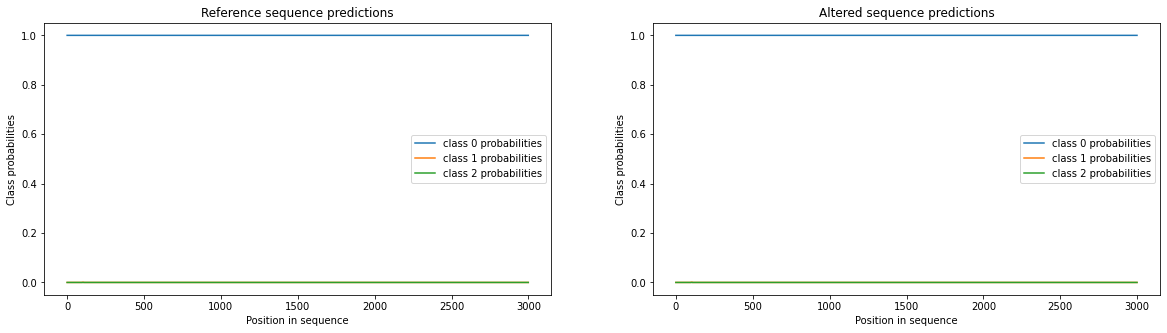

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Reference sequence predictions')
ax[0].plot(ref_probs_nt[:, 0], label='class 0 probabilities')
ax[0].plot(ref_probs_nt[:, 1], label='class 1 probabilities')
ax[0].plot(ref_probs_nt[:, 2], label='class 2 probabilities')
ax[0].legend()
ax[0].set_xlabel("Position in sequence")
ax[0].set_ylabel("Class probabilities")

ax[1].set_title('Altered sequence predictions')
ax[1].plot(alt_probs_nt[:, 0], label='class 0 probabilities')
ax[1].plot(alt_probs_nt[:, 1], label='class 1 probabilities')
ax[1].plot(alt_probs_nt[:, 2], label='class 2 probabilities')
ax[1].legend()
ax[1].set_xlabel("Position in sequence")
ax[1].set_ylabel("Class probabilities")

plt.show()

Here we can see that the model basically predicts that there are no splicing sites in both reference and altered sequence.


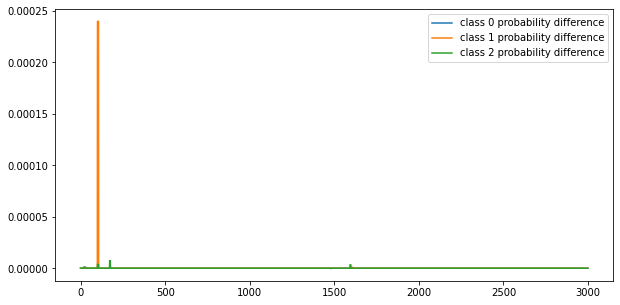

In [ ]:
# calculate difference in probabilities
prob_diff = alt_probs_nt - ref_probs_nt

plt.figure(figsize=(10, 5))
plt.plot(prob_diff[:, 0], label='class 0 probability difference')
plt.plot(prob_diff[:, 1], label='class 1 probability difference')
plt.plot(prob_diff[:, 2], label='class 2 probability difference')

plt.legend()
plt.show()

One of the variants in the VCF file actually does change the splicing pattern.

In [ ]:
seq_len_change = 3000

mb = []

for s_ind in np.arange(0,11,1):
  class SpliceAIDatasetDummyTargets(SpliceAIDataset):
    """
    Dataset class for evaluation. This class is exactly like `SpliceAIDataset`, 
    but loads data from a `pd.DataFrame` instead of file 
    and provides dummy targets (just for code compatibility), 
    since there are no targets available for the VCF variants data.
    """
    def __init__(
        self,
        data,
        tokenizer,
        max_seq_len=512,
        seq_len = 3000,
        targets_len=2,
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.targets_offset = (seq_len - targets_len) // 2
        self.targets_len = targets_len

        ref_seqs['targets'] = ref_seqs.apply(lambda x: pd.Series({'targets': np.zeros(self.targets_len)}), axis=1)
        alt_seqs['targets'] = alt_seqs.apply(lambda x: pd.Series({'targets': np.zeros(self.targets_len)}), axis=1)

        self.data.columns = ['seq', 'targets']

# instantiate datasets of reference and altered sequences
  ref_dataset = SpliceAIDatasetDummyTargets(ref_seqs, tokenizer, seq_len=seq_len)
  alt_dataset = SpliceAIDatasetDummyTargets(alt_seqs, tokenizer, seq_len=seq_len)

  sample_idx = 0
  ref_sample = ref_dataset[sample_idx]
  alt_sample = alt_dataset[sample_idx]
  with torch.no_grad():
      ref_output = model.forward(
          input_ids=torch.tensor(ref_sample['input_ids']).unsqueeze(0), 
          attention_mask=torch.tensor(ref_sample['attention_mask']).unsqueeze(0),
          token_type_ids=torch.tensor(ref_sample['token_type_ids']).unsqueeze(0),
      )

      alt_output = model.forward(
          input_ids=torch.tensor(alt_sample['input_ids']).unsqueeze(0), 
          attention_mask=torch.tensor(alt_sample['attention_mask']).unsqueeze(0),
          token_type_ids=torch.tensor(alt_sample['token_type_ids']).unsqueeze(0),
      )

  ref_probs = ref_output.logits.squeeze().sigmoid()
  alt_probs = alt_output.logits.squeeze().sigmoid()

  ref_token_repeats = []
  for token in tokenizer.convert_ids_to_tokens(ref_sample['input_ids']):
      if token not in tokenizer.all_special_tokens:
          ref_token_repeats.append(len(token))
      else:
          ref_token_repeats.append(0)

  alt_token_repeats = []
  for token in tokenizer.convert_ids_to_tokens(alt_sample['input_ids']):
      if token not in tokenizer.all_special_tokens:
          alt_token_repeats.append(len(token))
      else:
          alt_token_repeats.append(0)

# repeat values length-of-token times to obtain per-nucleotide probabilities
  ref_probs_nt = torch.repeat_interleave(ref_probs, 
                                        torch.tensor(ref_token_repeats), 
                                        dim=0)

  alt_probs_nt = torch.repeat_interleave(alt_probs, 
                                        torch.tensor(alt_token_repeats), 
                                        dim=0)

  prob_diff = alt_probs_nt - ref_probs_nt

  for i in range(len(prob_diff)):
    #if prob_diff[i,0] < 0.5 and (prob_diff[i,1] > 0.5 or prob_diff[i,2] > 0.5):
      mb.append([i,ref_probs_nt,alt_probs_nt])

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
